In [1]:
from fastai.vision.all import *
import cv2
import skimage as sm
import skimage.io
import tifffile
path = Path('/notebooks/deepLearningPaper/UNetCellDivision3')

In [2]:
# Training

valid_fnames = (path/'valid.txt').read_text().split('\n')
path_im = path/'dat3/train_images'
path_lbl = path/'dat3/train_masks'
codes = np.loadtxt(path/'codes.txt', dtype=str)
# codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)
get_msk = lambda o: path/f'dat3/train_masks'/f'{o.stem}_mask{o.suffix}'

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/f'dat3/train_images', bs=8)
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean() 
opt = ranger
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt).to_fp16()

# learn.load(f'UNetCellDivision3')


In [3]:
learn.load(f'UNetCellDivision3')

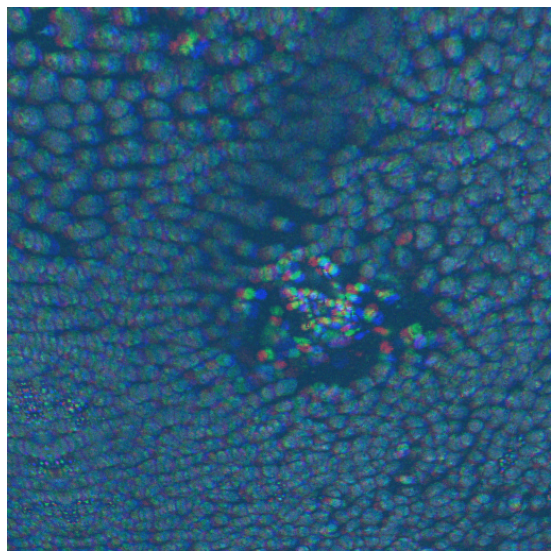

In [3]:
dls.show_batch(max_n=1, figsize=(14,10))

SuggestedLRs(valley=tensor(2.5119e-05))

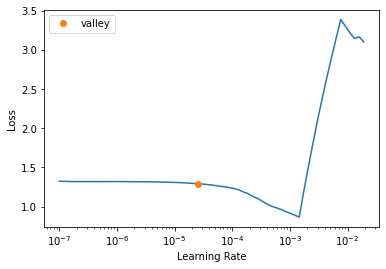

In [6]:
learn.lr_find()

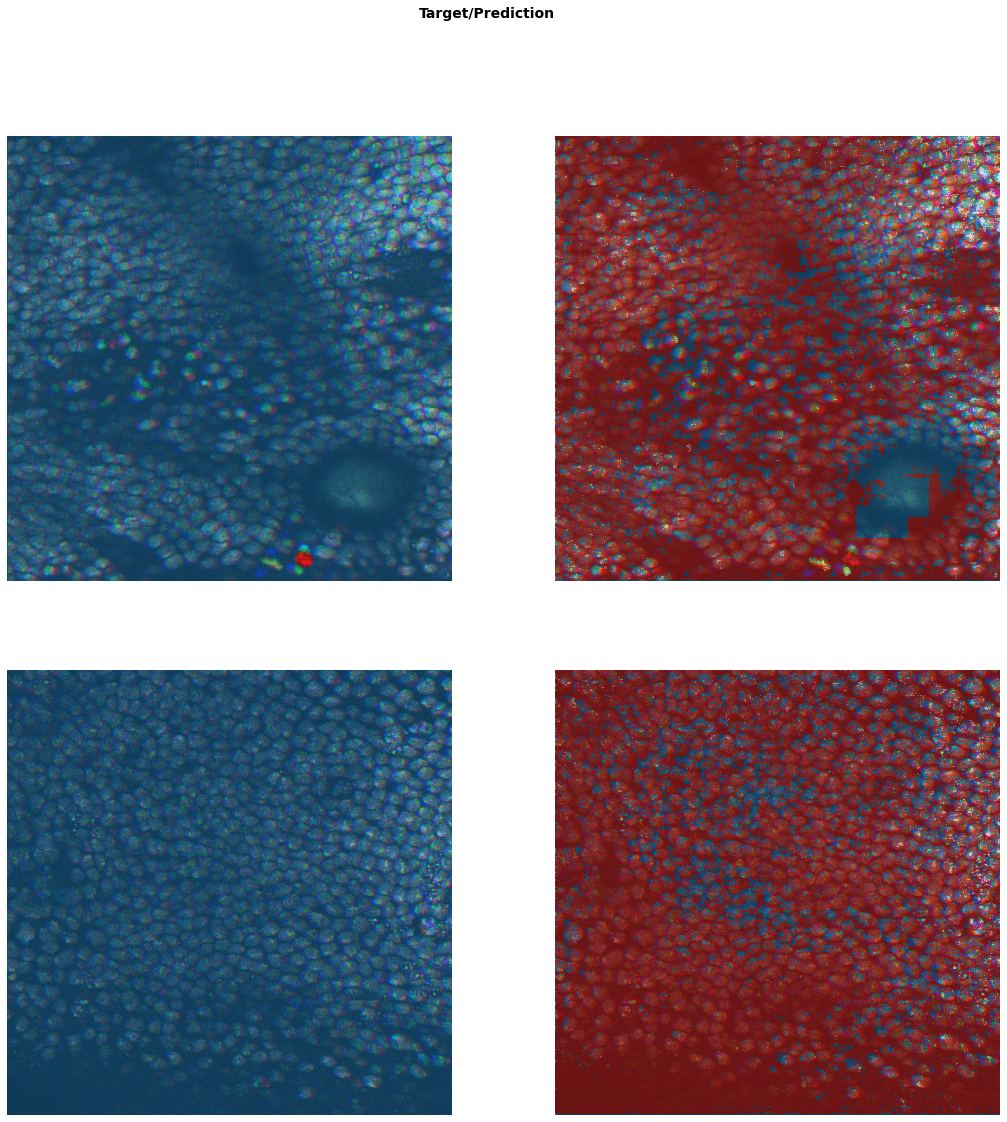

In [3]:
learn.show_results(max_n=2, figsize=(18,18))

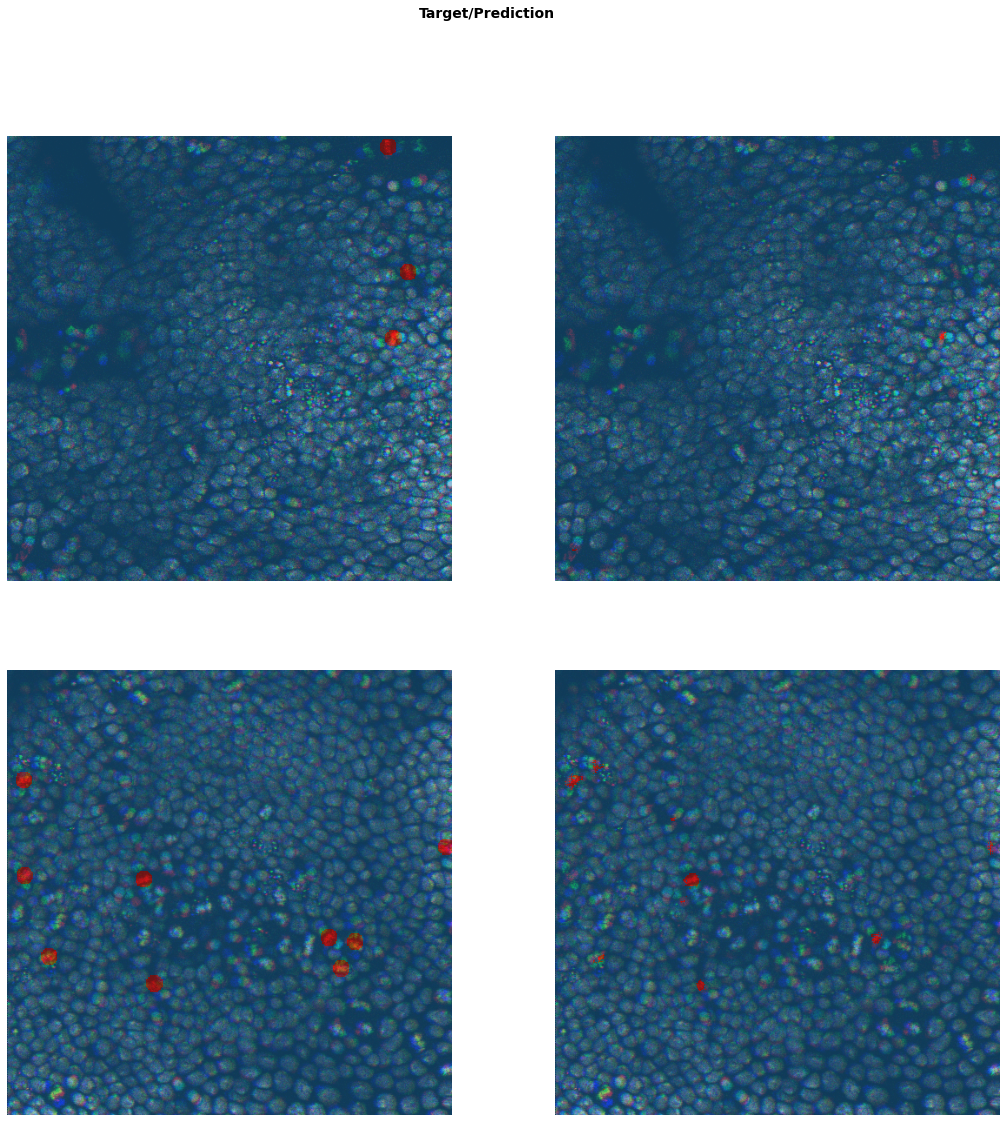

In [4]:
learn.fine_tune(2, base_lr=1e-4)
# learn.save(f'UNetCellDivision3_1')
learn.show_results(max_n=2, figsize=(18,18))

SuggestedLRs(valley=tensor(4.3652e-05))

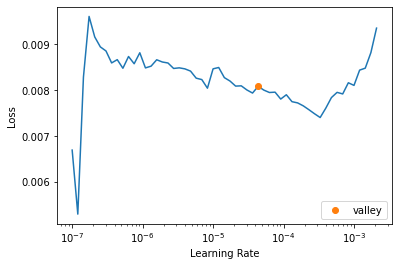

In [7]:
learn.unfreeze()
learn.lr_find()

In [8]:
learn.fine_tune(1, base_lr=1e-5)
# learn.save(f'UNetCellDivision3_1')

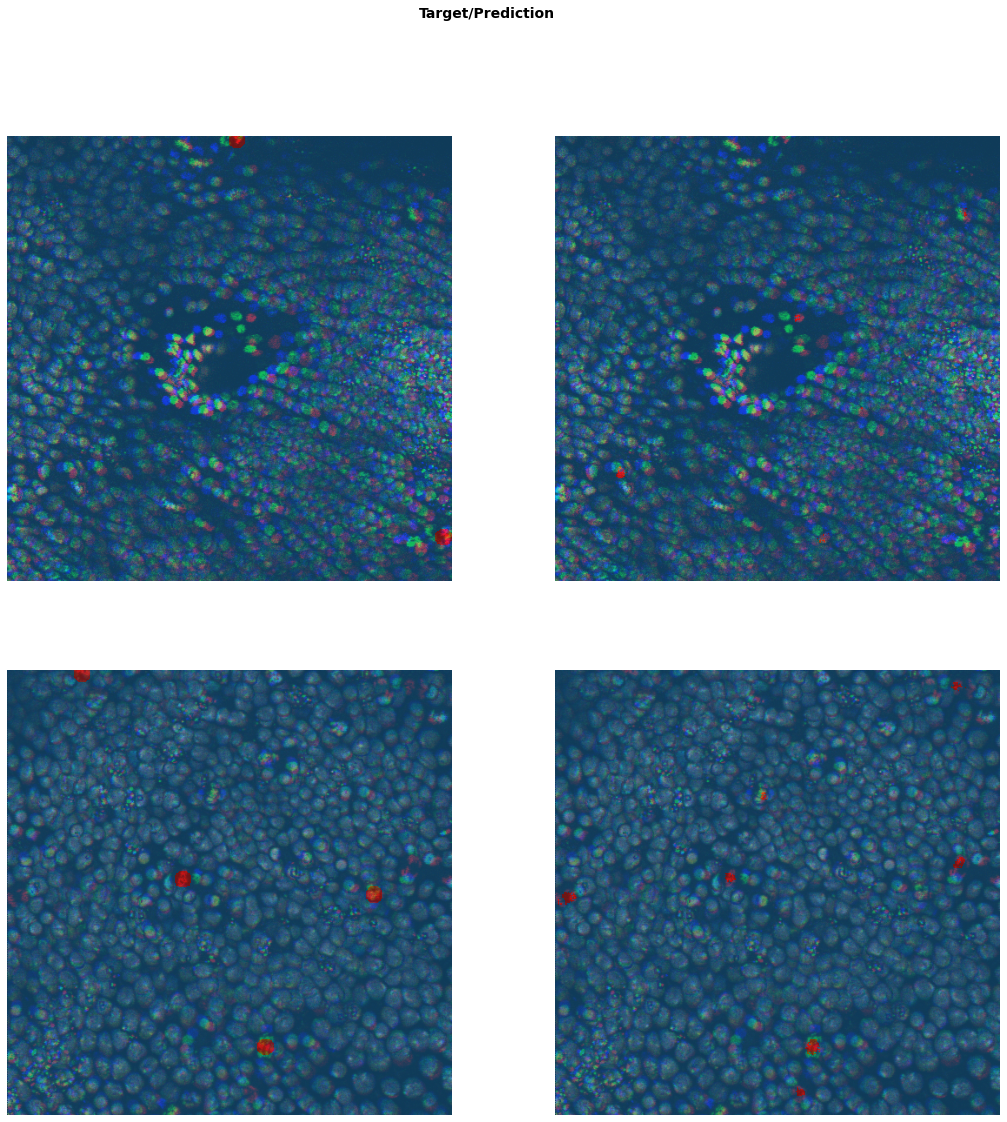

In [10]:
learn.show_results(max_n=2, figsize=(18,18))

In [8]:
model = learn.model
from torchsummary import summary
summary(model, (512, 512, 3))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[2, 512, 512, 3] to have 3 channels, but got 512 channels instead